# Fitting to a real (thick) plate

- order: 2

This notebook shows how to fit the physical parameters of a plate to a real recording.

In [ ]:
# | hide

import jax
import jax.numpy as jnp
import numpy as np
import optax
import soundfile as sf
import soxr
from IPython.display import Audio
from matplotlib import pyplot as plt
from scipy.signal import butter, freqz, lfilter
from tqdm import tqdm

from jaxdiffmodal.ftm import (
    PlateParameters,
    plate_eigenvalues,
    plate_wavenumbers,
)
from jaxdiffmodal.losses import (
    spectral_convergence_loss,
    spectral_wasserstein,
)
from jaxdiffmodal.lpc import lpc_cpu_solve
from jaxdiffmodal.utils import (
    bark2hz,
    display_audio_with_title,
    hz2bark,
    iir_filter_parallel,
    safe_log,
    tf_freqz,
    to_db,
)

In [ ]:
# | hide

n_max_modes_x = 10
n_max_modes_y = 10
n_modes = 100
sample_rate = 44100
dt = 1 / sample_rate

params = PlateParameters(
    E=2e12,
    nu=0.3,
    rho=7850,
    h=5e-4,
    l1=0.2,
    l2=0.3,
    Ts0=0,
    d1=4e-2,
)

Load a recording of a struck plate and preprocess it

Resampling from 48000 to 44100
The sample rate is 44100


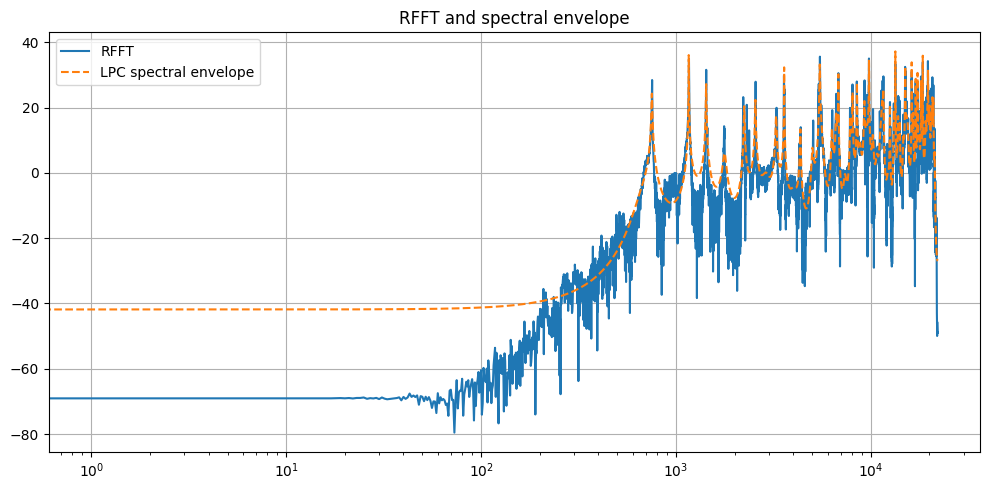

In [ ]:
# | code-fold: true

stiff_string_real, file_sr = sf.read("audio/single.wav")
if file_sr != sample_rate:
    print(f"Resampling from {file_sr} to {sample_rate}")
    stiff_string_real = soxr.resample(
        stiff_string_real,
        in_rate=file_sr,
        out_rate=sample_rate,
    )

print("The sample rate is", sample_rate)

scale = 1
duration = 2.0
offset = int(0.00 * sample_rate)
stop = int(1 * sample_rate)
# ensure the audio has exactly the same length
stiff_string_real = stiff_string_real[offset : offset + stop]

# high pass filter the audio
b, a = butter(N=4, Wn=800, btype="high", fs=sample_rate)
stiff_string_real = lfilter(b, a, stiff_string_real)

# get the rfft of the real audio
u_stiff_string_rfft = np.fft.rfft(stiff_string_real)

# get the spectral envelope
a_lpc_cpu_solve_autocorr, g_lpc_solve_autocorr = lpc_cpu_solve(
    stiff_string_real,
    128,
    method="autocorrelation",
    biased=False,
)

w, h = freqz(
    b=g_lpc_solve_autocorr,
    a=np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    worN=u_stiff_string_rfft.shape[0],
    fs=sample_rate,
)

# impulse response
H = g_lpc_solve_autocorr / np.fft.rfft(
    np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    n=sample_rate,
)
y = np.fft.irfft(H, n=sample_rate)
y_rfft = np.abs(np.fft.rfft(y))

t = np.linspace(0, duration, len(stiff_string_real))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("RFFT and spectral envelope")
ax.semilogx(to_db(np.abs(u_stiff_string_rfft)), label="RFFT")
ax.semilogx(w, to_db(np.abs(h)), label="LPC spectral envelope", ls="--")
ax.grid("both")
ax.legend()
fig.tight_layout()

display_audio_with_title(stiff_string_real, sample_rate, "Original")
display_audio_with_title(y, sample_rate, "LPC fit and filtered")

Sample the envelope using the bark scale.

In [ ]:
# | code-fold: true

hz_range = np.array([200, 20000])
barkrange = hz2bark(hz_range)
worN = bark2hz(np.linspace(barkrange[0], barkrange[1], 20000))

w, h = freqz(
    g_lpc_solve_autocorr,
    a=np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    worN=worN,
    fs=sample_rate,
)
target_freq_resp = jnp.abs(h) / jnp.max(jnp.abs(h))

Define the initial parameters and constraints.

In [ ]:
# | code-fold: true

RANGE_BENDING_STIFFNESS = 15000

rng = np.random.default_rng(654)
pars = {
    "bending_stiffness": rng.normal(),
    "gamma_mu": jnp.linspace(5, 15, n_modes),
    "d1": rng.normal(),
    "d3": rng.normal(),
    "Ts0": rng.normal(),
    "l1": rng.normal(),
    "l2": rng.normal(),
    "z0": rng.normal(size=(n_modes, 1)).astype(np.float32),
    "gain": rng.normal(scale=1e-3),
    "zero_radii": rng.normal(size=(n_modes)).astype(np.float32),
    "zero_angles": rng.normal(size=(n_modes)).astype(np.float32),
}


def get_bending_stiffness(params):
    return jax.nn.sigmoid(params["bending_stiffness"]) * RANGE_BENDING_STIFFNESS


def get_l1(params):
    return jax.nn.sigmoid(params["l1"])


def get_l2(params):
    return jax.nn.sigmoid(params["l2"])


def get_z0(params):
    return params["z0"]


def get_gamma_mu(params):
    return -jax.nn.relu(params["gamma_mu"])
    # return -jnp.exp(params["gamma_mu"])


def get_Ts0(params):
    return 0.0


def get_gain(params):
    return params["gain"]


def get_zeros(pars):
    return jax.nn.sigmoid(pars["zero_radii"]) * jnp.exp(
        2j * np.pi * jax.nn.sigmoid(pars["zero_angles"])
    )

Simulate the plate using the initial parameters.

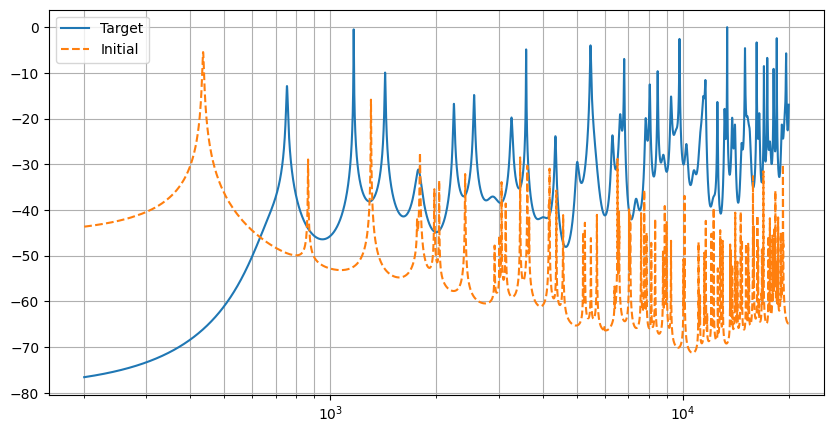

In [ ]:
# | code-fold: true


def tf_modified(
    pars,
    lambda_mu,
    dt,
):
    omega_mu_squared = (
        get_bending_stiffness(pars) * lambda_mu**2 + get_Ts0(pars) * lambda_mu
    )
    gamma_mu = get_gamma_mu(pars)
    omega_mu = jnp.sqrt(omega_mu_squared - gamma_mu**2)

    # discretise
    radius = jnp.exp(gamma_mu * dt)
    real = radius * jnp.cos(omega_mu * dt)

    zeros = get_zeros(pars)
    b1 = -2.0 * zeros.real
    b2 = zeros.real**2 + zeros.imag**2

    a1 = -2.0 * real
    a2 = radius**2

    ones = jnp.ones_like(lambda_mu)

    b = jnp.stack([ones, b1, b2], axis=-1)
    a = jnp.stack([ones, a1, a2], axis=-1)
    return b, a


def simulate_membrane(pars):
    wnx, wny = plate_wavenumbers(
        n_max_modes_x,
        n_max_modes_y,
        get_l1(pars),
        get_l2(pars),
    )
    lambda_mu = plate_eigenvalues(wnx, wny).reshape(-1)
    lambda_mu = lambda_mu.reshape(-1).sort()[:n_modes]

    b, a = tf_modified(pars, lambda_mu, dt)
    b = b * get_z0(pars) * get_gain(pars)
    h = tf_freqz(b, a, worN, sample_rate)
    pred_freq_resp = jnp.mean(jnp.abs(h), axis=0)
    return pred_freq_resp, b, a


initial_freq_resp, b, a = simulate_membrane(pars)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogx(
    worN,
    to_db(target_freq_resp),
    label="Target",
)
ax.semilogx(
    worN,
    to_db(initial_freq_resp),
    label="Initial",
    ls="--",
)
ax.grid(which="both")
_ = ax.legend()


x = jnp.zeros(shape=(sample_rate), dtype=jnp.float32)
x = x.at[0].set(1.0)
pred_imp_resp = iir_filter_parallel(b, a, x).mean(axis=1)

display_audio_with_title(y, sample_rate, "Target")
display_audio_with_title(pred_imp_resp, sample_rate, "Initial")

Optimise the parameters using gradient descent.

In [ ]:
# | code-fold: true

iterations = 30_000
learning_rate = 1e-2
scheduler = optax.cosine_onecycle_schedule(
    transition_steps=iterations,
    peak_value=learning_rate,
)
optimiser = optax.chain(
    optax.clip_by_global_norm(2.0),
    optax.adam(learning_rate=scheduler),
)
state = optimiser.init(pars)


@jax.jit
def train_step(pars, state):
    def loss_fn(pars):
        pred_freq_resp, b, a = simulate_membrane(pars)

        log_pred_freq_resp = safe_log(pred_freq_resp)
        log_target_freq_resp = safe_log(target_freq_resp)

        lin_diff = pred_freq_resp - target_freq_resp
        log_diff = log_pred_freq_resp - log_target_freq_resp

        lin_l2_loss = jnp.mean(
            jnp.square(
                lin_diff,
            ),
        )
        log_l1_loss = jnp.mean(
            jnp.abs(
                log_diff,
            ),
        )
        sc_loss = spectral_convergence_loss(
            log_pred_freq_resp,
            log_target_freq_resp,
        )
        ot_loss = jnp.mean(
            spectral_wasserstein(
                pred_freq_resp,
                target_freq_resp,
                squared=True,
                is_mag=True,
            )
        )

        return lin_l2_loss + log_l1_loss * 0.1 + sc_loss + ot_loss * 0.001

    loss, grads = jax.value_and_grad(loss_fn)(pars)

    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


bar = tqdm(range(iterations))
for i in bar:
    pars, state, loss = train_step(pars, state)
    bar.set_description(
        f"Loss: {loss:.3f}, bending_stiffness: {get_bending_stiffness(pars):.3f}, l1: {get_l1(pars):.3f}, l2: {get_l2(pars):.3f}"
    )

Loss: 0.158, bending_stiffness: 3998.537, l1: 0.738, l2: 0.357: 100%|██████████| 30000/30000 [00:47<00:00, 632.80it/s]


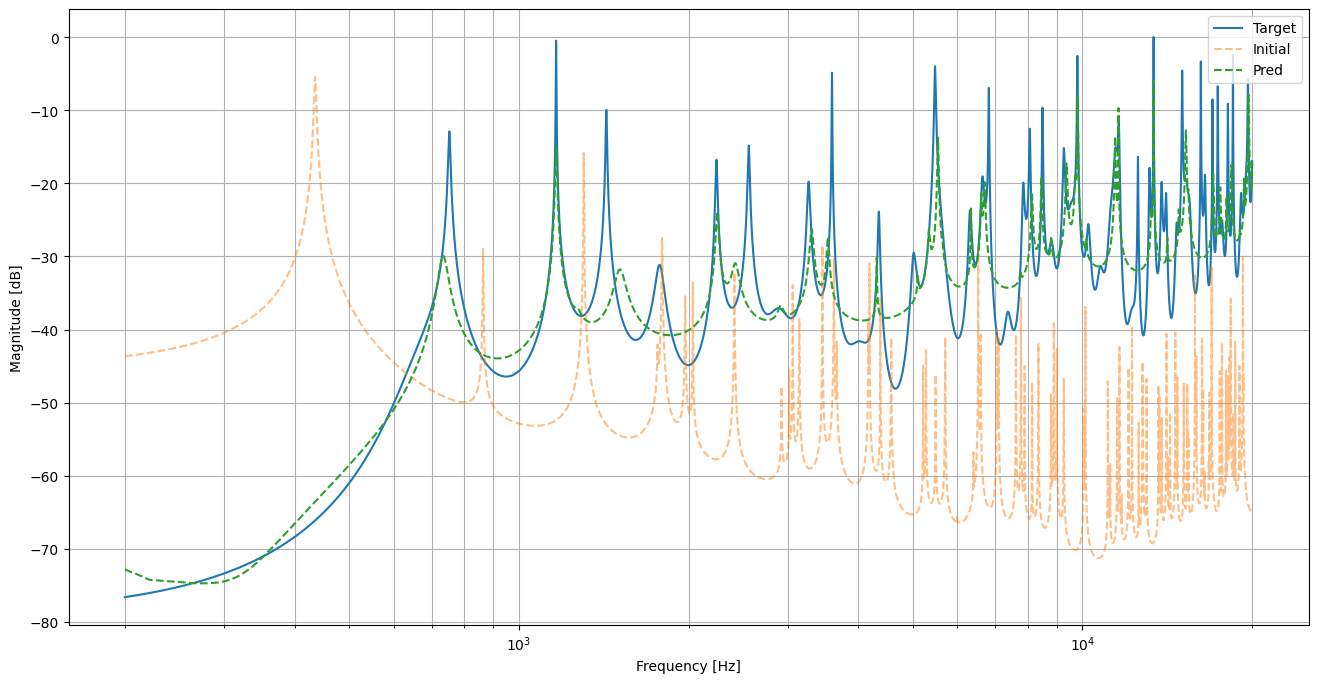

In [ ]:
# | echo: false

pred_freq_resp, b, a = simulate_membrane(pars)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.semilogx(
    worN,
    to_db(target_freq_resp),
    label="Target",
)
ax.semilogx(
    worN,
    to_db(initial_freq_resp),
    label="Initial",
    ls="--",
    alpha=0.5,
)
ax.semilogx(
    worN,
    to_db(pred_freq_resp),
    label="Pred",
    ls="--",
)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude [dB]")
ax.grid(which="both")
_ = ax.legend(loc="upper right")

x = jnp.zeros(shape=(sample_rate), dtype=jnp.float32)
x = x.at[0].set(1.0)
pred_imp_resp = iir_filter_parallel(b, a, x).mean(axis=1)

display_audio_with_title(y, sample_rate, "Target")
display_audio_with_title(pred_imp_resp, sample_rate, "Optimised")